# Chapter 2: machine learning for S&P500 prediction 

**by Li Shen, Ph.D.**

**E-mail: shenli.sam@gmail.com**

**LinkedIn: https://www.linkedin.com/in/lshen**

**Updated: 2016/08/18**

## Summary

In this chapter, machine learning techniques are used to predict the log returns of the daily close prices of S&P500. The machine learning methods are used to either directly predict the log returns or combine with the ARMA predictions in a hybrid fashion from the previous chapter.

NOTE: this is the 2nd part in a series of Python notebooks that exploit machine learning for financial time series. The 1st part can be viewed here:

**Chapter 1: data analysis of S&P500 daily close prices** -  http://nbviewer.jupyter.org/github/lishen/SP500_ML/blob/master/SP500%20pred%20with%20ML%20-%20Chapter%201.ipynb

## Load data and libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


First, load the S&P500 daily log return data saved from the previous chapter, including the ARMA residuals. This dataset includes the daily closing prices of S&P500 **from 1996/06/17 to 2016/06/13 (20 years)**, of which the **time period of 1996/06/17-2011/06/17 (15 years) is used as train set and the time period of 2011/06/20-2016/06/13 (5 years)** is used as test set.

In [2]:
ts_logrtX = pd.read_csv('saved_dat/ts_logrtX.csv', index_col=0)
ts_logrtX.index = pd.to_datetime(ts_logrtX.index)
arma_all_resid = np.load('saved_dat/arma_all_resid.npy')
split_date = '2011-06-18'
lrt_train = ts_logrtX.ix[:split_date, ['sp500_logrt']]
lrt_test = ts_logrtX.ix[split_date:, ['sp500_logrt']]

In [3]:
print 'Dataset size:', ts_logrtX.shape
ts_logrtX.head(n=3)

Dataset size: (5032, 3)


,sp500_logrt,hl_logra,sqr_vol
Date,,,
1996-06-17,-0.001037,1.430310,0.546269
1996-06-18,-0.004671,1.613422,0.610975
1996-06-19,-0.000151,1.483869,0.619363


The dataset includes S&P500 daily log returns as well as the log-transformed high-low ranges and square-root-transformed volumes. The latters are used as exogenous data.

## 2.1 Lagged data and feature selection

### 2.1.1 Lagged log return data

Most machine learning algorithms expect tabular data as inputs. Therefore, we need to convert time series data into such format. The following is a utility function that converts single-column time series into lagged predictors.

In [4]:
def ts_to_lagged_df(ts, col_id, index=None, lag_size=5):
    '''Convert a time series to lagged dataframe
    Args:
        ts (DataFrame): a dataframe, series or array containing the 
                        time series. If it is a dataframe or array, 
                        the 2nd dimension must have a size of 1.
        col_id (str): if the col id is N, all columns will be named 
                      as N1, N2, N3, ...
        index ([DatetimeIndex]): if not provided, will use the index 
                                 from the input dataframe or series, 
                                 or integers if the input is array.
        lag_size ([int]): the lag size to use
    Returns: a dataframe containing the lagged values in columns.
    '''
    # Sanity check and extract data and index.
    if isinstance(ts, pd.Series):
        dat = ts.values.ravel()
        if index is None:
            df_idx = ts.index[lag_size:]
    elif isinstance(ts, pd.DataFrame):
        assert ts.shape[1] == 1
        dat = ts.values.ravel()
        if index is None:
            df_idx = ts.index[lag_size:]
    else:
        assert isinstance(ts, np.ndarray)
        assert ts.ndim <= 2
        if ts.ndim == 2:
            assert ts.shape[1] == 1
        dat = ts.ravel()
        if index is None:
            df_idx = range(len(dat) - lag_size)
    if index is not None:
        assert len(index) == len(dat)
        df_idx = index[lag_size:]
    # Convert to lagged dataframe.
    lagged_df = concatenate(
        map(lambda x: dat[range(x - 1, x - 1 - lag_size, -1)], 
            range(lag_size, len(dat)))
    ).reshape((-1, lag_size))
    lagnames = map(lambda x: col_id + str(x), range(1, lag_size + 1))
    lagged_df = pd.DataFrame(lagged_df, index=df_idx, columns=lagnames)
    return lagged_df

To apply machine learning, we must first decide what are the predictors and what are the targets. Here, the targets are the S&P500 daily closing prices. The predictors are the lagged S&P500 closing prices and the lagged high-low ranges and volumes. I'll use a **max lag size of 20** to construct the tabular data. This is an arbitrary choice and is mainly driven by computational cost. Later I'll treat the lag size as a hyperparameter and optimize it.

In [5]:
max_lag = 20
lagged_lrt_df = ts_to_lagged_df(ts_logrtX[['sp500_logrt']], 'L', lag_size=max_lag)
lagged_rng_df = ts_to_lagged_df(ts_logrtX[['hl_logra']], 'R', lag_size=max_lag)
lagged_vol_df = ts_to_lagged_df(ts_logrtX[['sqr_vol']], 'V', lag_size=max_lag)
print 'Dimensions of lagged log return data:', lagged_lrt_df.shape
lagged_lrt_df.head(n=3)

Dimensions of lagged log return data: (5012, 20)


,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Date,,,,,,,,,,,,,,,,,,,,
1996-07-16,-0.025691,0.000805,-0.015964,0.001999,0.003381,-0.007481,-0.022500,-0.001798,-0.003364,0.007798,0.003106,0.006242,-0.006137,-0.000553,0.003010,0.007134,0.000211,-0.000151,-0.004671,-0.001037
1996-07-17,-0.002273,-0.025691,0.000805,-0.015964,0.001999,0.003381,-0.007481,-0.022500,-0.001798,-0.003364,0.007798,0.003106,0.006242,-0.006137,-0.000553,0.003010,0.007134,0.000211,-0.000151,-0.004671
1996-07-18,0.009030,-0.002273,-0.025691,0.000805,-0.015964,0.001999,0.003381,-0.007481,-0.022500,-0.001798,-0.003364,0.007798,0.003106,0.006242,-0.006137,-0.000553,0.003010,0.007134,0.000211,-0.000151


Split the above datasets into train and test sets.

In [6]:
lagged_lrt_train = lagged_lrt_df[:split_date]
lagged_lrt_test = lagged_lrt_df[split_date:]
lagged_rng_train = lagged_rng_df[:split_date]
lagged_rng_test = lagged_rng_df[split_date:]
lagged_vol_train = lagged_vol_df[:split_date]
lagged_vol_test = lagged_vol_df[split_date:]
print 'Train set shape:', lagged_lrt_train.shape
print 'Test set shape:', lagged_lrt_test.shape

Train set shape: (3758, 20)
Test set shape: (1254, 20)


To improve optimization, scale the train set predictors to have zero mean and unit variance. Apply the same scaling to the test predictors as well.

*Note: in the strict sense, scaling shall be done within a cross-validation procedure. I did this at the beginning of the model building simply for convenience.*

In [7]:
from sklearn import preprocessing
llrt_scaler = preprocessing.StandardScaler().fit(lagged_lrt_train)
llrt_train_scaled = llrt_scaler.transform(lagged_lrt_train)
llrt_test_scaled = llrt_scaler.transform(lagged_lrt_test)
##
lrng_scaler = preprocessing.StandardScaler().fit(lagged_rng_train)
lrng_train_scaled = lrng_scaler.transform(lagged_rng_train)
lrng_test_scaled = lrng_scaler.transform(lagged_rng_test)
##
lvol_scaler = preprocessing.StandardScaler().fit(lagged_vol_train)
lvol_train_scaled = lvol_scaler.transform(lagged_vol_train)
lvol_test_scaled = lvol_scaler.transform(lagged_vol_test)

Create S&P500 log return targets.

In [8]:
llrt_train_y = lrt_train[max_lag:].values.ravel()
llrt_test_y = lrt_test.values.ravel()

Calculate and visualize the correlation coefficients between the 20 predictors on the train set.

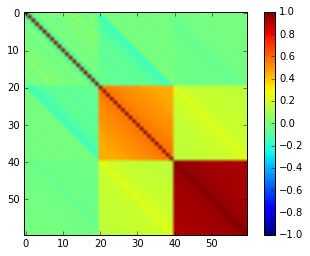

In [9]:
lcombined_train_scaled = c_[llrt_train_scaled, lrng_train_scaled, lvol_train_scaled]
lagnames = concatenate([lagged_lrt_train.columns, 
                        lagged_rng_train.columns, 
                        lagged_vol_train.columns])
lcombined_train_cor = pd.DataFrame(corrcoef(lcombined_train_scaled, rowvar=False), 
                                   index=lagnames, columns=lagnames)
imshow(lcombined_train_cor, vmin=-1, vmax=1)
colorbar()

This is a very interesting heatmap revealing correlations bewteen lagged log returns and other predictors. The lagged log returns (upper left) display almost zero correlations. On the contrary, the lagged high-low ranges (center) show medium-high correlations. The lagged volumes (lower right) show very strong correlations. There is also a noticeable degree of correlation between the high-low range and volume. **Since both high-low range and volume are related to volitility, this is just an evidence of volitility clustering.**

Another noticeable thing is the weak and negative correlation bewteen log return and high-low range on the same day. **That means, if the high-low range is larger, the S&P500 is more likely to be losing than winning on the same day on average.**

### 2.1.2 Lagged ARMA residuals

Use the same procedure as above on the ARMA residuals to set up predictors and targets, and then apply normalization. The purpose will become more clear when using a hybrid approach to combine ARMA and other machine learning methods.

In [9]:
arma_max_order = 5  # this was used in Chapter 1.
arma_train_resid = np.load('saved_dat/arma_train_resid.npy')
arma_test_resid = np.load('saved_dat/arma_test_resid.npy')
# Pad the train set residuals with its means to make it equal
# length with the log return series.
arma_train_resid = concatenate([repeat(arma_train_resid.mean(), arma_max_order), 
                                arma_train_resid])
arma_all_resid = concatenate((arma_train_resid, arma_test_resid))
lagged_resid_df = ts_to_lagged_df(arma_all_resid, 'S', index=ts_logrtX.index, 
                                  lag_size=max_lag)
lagged_resid_train = lagged_resid_df[:split_date]
lagged_resid_test = lagged_resid_df[split_date:]
lresid_scaler = preprocessing.StandardScaler().fit(lagged_resid_train)
lresid_train_scaled = lresid_scaler.transform(lagged_resid_train)
lresid_test_scaled = lresid_scaler.transform(lagged_resid_test)
lresid_train_y = arma_train_resid[max_lag:]
lresid_test_y = arma_test_resid

Save all the transformed data into a zipped file for easy loading later or by other programs.

In [125]:
_ = '''
savez('saved_dat/lagged_lrtX_traintest.npz', 
      llrt_train_scaled=llrt_train_scaled, 
      llrt_test_scaled=llrt_test_scaled,
      lrng_train_scaled=lrng_train_scaled,
      lrng_test_scaled=lrng_test_scaled,
      lvol_train_scaled=lvol_train_scaled,
      lvol_test_scaled=lvol_test_scaled,
      llrt_train_y=llrt_train_y,
      llrt_test_y=llrt_test_y,
      lresid_train_scaled=lresid_train_scaled,
      lresid_test_scaled=lresid_test_scaled,
      lresid_train_y=lresid_train_y,
      lresid_test_y=lresid_test_y)
'''

*The following code is used to load all the data back into memory in case the notebook is restarted.*

In [3]:
arma_max_order = 5  # this was used in Chapter 1.
max_lag = 20
d_ = load('saved_dat/lagged_lrtX_traintest.npz')
llrt_train_scaled = d_['llrt_train_scaled']
llrt_test_scaled = d_['llrt_test_scaled']
lrng_train_scaled = d_['lrng_train_scaled']
lrng_test_scaled = d_['lrng_test_scaled']
lvol_train_scaled = d_['lvol_train_scaled']
lvol_test_scaled = d_['lvol_test_scaled']
llrt_train_y = d_['llrt_train_y']
llrt_test_y = d_['llrt_test_y']
lresid_train_scaled = d_['lresid_train_scaled']
lresid_test_scaled = d_['lresid_test_scaled']
lresid_train_y = d_['lresid_train_y']
lresid_test_y = d_['lresid_test_y']
%xdel d_

### 2.1.3 Assess feature importance with randomized Lasso and random forest

There is no assumption regarding which lagged values are more useful than others as predictors for S&P500 log returns. So here I'll use two feature selection methods - randomized Lasso and random forest to assess their importance.

In [13]:
from sklearn.linear_model import RandomizedLasso
import warnings
rand_lasso = RandomizedLasso(n_resampling=3000, normalize=False, random_state=1, n_jobs=1)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rand_lasso.fit(lcombined_train_scaled, llrt_train_y)

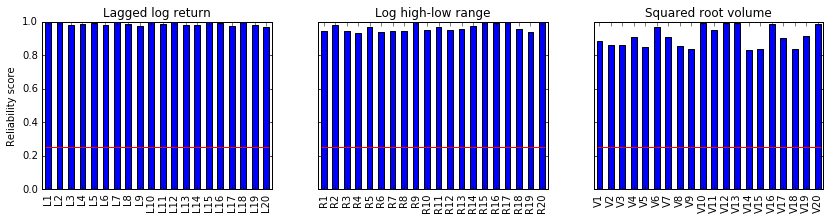

In [14]:
lasso_scores = pd.DataFrame(rand_lasso.scores_, index=lagnames, 
                            columns=['reliability score'])
fig,axes = subplots(1, 3, sharey=True)
fig.set_size_inches([14, 3])
lasso_scores['L1':'L20'].plot(kind='bar', legend=False, ax=axes[0])
lasso_scores['R1':'R20'].plot(kind='bar', legend=False, ax=axes[1])
lasso_scores['V1':'V20'].plot(kind='bar', legend=False, ax=axes[2])
axes[0].hlines(y=.25, xmin=-.25, xmax=max_lag - .75, colors='r')
axes[1].hlines(y=.25, xmin=-.25, xmax=max_lag - .75, colors='r')
axes[2].hlines(y=.25, xmin=-.25, xmax=max_lag - .75, colors='r')
axes[0].set_ylabel('Reliability score')
#axes[1].set_ylabel('Reliability score')
#axes[2].set_ylabel('Reliability score')
axes[0].set_title('Lagged log return')
axes[1].set_title('Log high-low range')
axes[2].set_title('Squared root volume')

There is really no distinction in reliability scores among the 20 lagged predictors and they are all well above the default 0.25 cutoff.

Now, use random forest to calculate feature importances. A potential advantage of random forest is that it may capture nonliearities in the data better than randomized Lasso.

In [15]:
from sklearn.ensemble import RandomForestRegressor
rand_forest = RandomForestRegressor(n_estimators=3000, n_jobs=2, random_state=1)
_ = rand_forest.fit(lcombined_train_scaled, llrt_train_y)

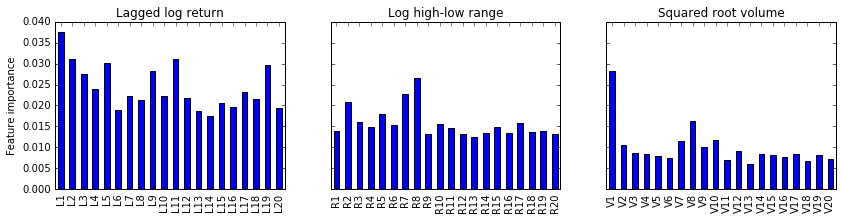

In [16]:
rf_scores = pd.DataFrame(rand_forest.feature_importances_, index=lagnames, 
                         columns=['feature importance'])
fig,axes = subplots(1, 3, sharey=True)
fig.set_size_inches([14, 3])
rf_scores['L1':'L20'].plot(kind='bar', legend=False, ax=axes[0])
rf_scores['R1':'R20'].plot(kind='bar', legend=False, ax=axes[1])
rf_scores['V1':'V20'].plot(kind='bar', legend=False, ax=axes[2])
axes[0].set_ylabel('Feature importance')
axes[0].set_title('Lagged log return')
axes[1].set_title('Log high-low range')
axes[2].set_title('Squared root volume')

Random forest seems to suggest some lagged values are more important than others. But still, there is no clear winner: the largest value is about only 2 times larger than the smallest value. On the other hand, the plot seems to suggest that recent lags are more important than remote lags.

The same feature selection procedure can be applied to the ARMA residuals:

In [17]:
rand_lasso_r = RandomizedLasso(n_resampling=3000, normalize=False, random_state=1, n_jobs=1)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rand_lasso_r.fit(lrcombined_train_scaled, lresid_train_y)

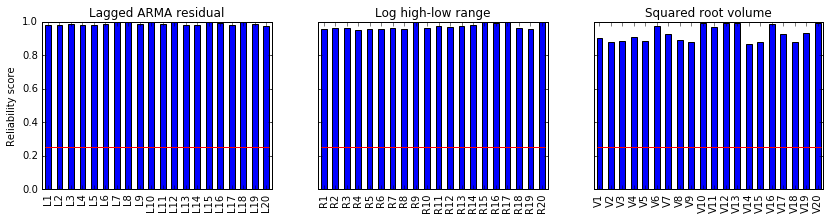

In [18]:
lasso_scores_r = pd.DataFrame(rand_lasso_r.scores_, index=lagnames, 
                              columns=['reliability score'])
fig,axes = subplots(1, 3, sharey=True)
fig.set_size_inches([14, 3])
lasso_scores_r['L1':'L20'].plot(kind='bar', legend=False, ax=axes[0])
lasso_scores_r['R1':'R20'].plot(kind='bar', legend=False, ax=axes[1])
lasso_scores_r['V1':'V20'].plot(kind='bar', legend=False, ax=axes[2])
axes[0].hlines(y=.25, xmin=-.25, xmax=max_lag - .75, colors='r')
axes[1].hlines(y=.25, xmin=-.25, xmax=max_lag - .75, colors='r')
axes[2].hlines(y=.25, xmin=-.25, xmax=max_lag - .75, colors='r')
axes[0].set_ylabel('Reliability score')
#axes[1].set_ylabel('Reliability score')
#axes[2].set_ylabel('Reliability score')
axes[0].set_title('Lagged ARMA residual')
axes[1].set_title('Log high-low range')
axes[2].set_title('Squared root volume')

In [19]:
rand_forest_r = RandomForestRegressor(n_estimators=3000, n_jobs=2, random_state=1)
rand_forest_r.fit(lrcombined_train_scaled, lresid_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=2, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

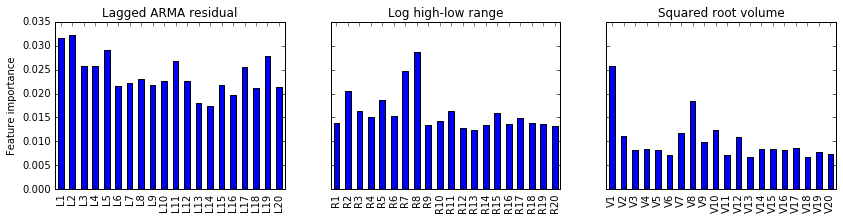

In [20]:
rf_scores_r = pd.DataFrame(rand_forest_r.feature_importances_, index=lagnames, 
                           columns=['feature importance'])
fig,axes = subplots(1, 3, sharey=True)
fig.set_size_inches([14, 3])
rf_scores_r['L1':'L20'].plot(kind='bar', legend=False, ax=axes[0])
rf_scores_r['R1':'R20'].plot(kind='bar', legend=False, ax=axes[1])
rf_scores_r['V1':'V20'].plot(kind='bar', legend=False, ax=axes[2])
axes[0].set_ylabel('Feature importance')
#axes[1].set_ylabel('Reliability score')
#axes[2].set_ylabel('Reliability score')
axes[0].set_title('Lagged ARMA residual')
axes[1].set_title('Log high-low range')
axes[2].set_title('Squared root volume')

The patterns are very similar to the log return data.

## 2.2 Strategy for machine learning

Here I give an outline of the machine learning strategy used for S&P500 prediction.

### 2.2.1 Hyperparameters optimization

Hyperparameter optimization is critical to the performance of machine learning algorithms. In this notebook, I mainly use [hyperopt](https://github.com/hyperopt/hyperopt), which is quite popular in the ML community. [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn) is a wrapper around the hyperopt, which allows one to optimize the hyperparameters for scikit-learn classifiers and regressors with pre-specified (or user-supplied) hyperparameter search spaces and built-in pipelines.

I have made significant contributions to the hyperopt-sklearn project, mainly through pull requests [#41](https://github.com/hyperopt/hyperopt-sklearn/pull/41) and [#44](https://github.com/hyperopt/hyperopt-sklearn/pull/44). They can be summarized as:

- Added sklearn regressors (it used to be only classifiers)
- Enhanced cross-validation by adding K-fold, shuffling, stratification, etc.
- Optimized hyperparameter search spaces for most classifiers and regressors.
- Added a time series lag selector.
- Added a "warm start" feature so that one can continue refining hyperparameters based on existing trials.
- Improved tests, code modularity and readability, bug fixes.

### 2.2.2 Hybrid approach to combine ARMA with other machine learning methods

The hybrid approach is described in this paper: *G. Peter Zhang, Time series forecasting using a hybrid ARIMA and neural network model, Neurocomputing, Volume 50, January 2003, Pages 159-175.* 

The key idea is that the nonlinear relationships captured by machine learning methods are not as robust as the linear relationships captured by ARMA. Consequently, machine learning may out-perform ARMA in certain cases but under-perform in other cases. This caused several conflicted reports in comparing ARMA and machine learning in literature. To imporve the robustness, machine learning can be used to make predictions of the ARMA residuals, i.e. capturing the nonlinearities that are missed by the ARMA, and then combine the predictions with the ARMA predictions to make final calls.

Load ARMA predictions from Chapter 1.

In [4]:
order_diff = max_lag - arma_max_order
arma_train_pred = np.load('saved_dat/arma_train_pred.npy')
arma_train_pred = arma_train_pred[order_diff:]
arma_test_pred = np.load('saved_dat/arma_test_pred.npy')

### 2.2.3 Miscellaneous stuffs

The following is a utility function copied from Chapter 1 to evaluate test performance at different time horizons.

In [5]:
def r2_in_days(target, pred, n_days):
    '''Evaluate R2 scores in different days
    Args:
        target, pred (array-like): targets and predictions for evaluation.
        n_days: time horizon in number of days for evaluation.
    Returns: a list of R2 scores.
    '''
    from sklearn.metrics import r2_score
    r2s = []
    for d in n_days:
        if d == 'all':
            r2s.append(r2_score(target, pred))
        else:
            r2s.append(r2_score(target[:d], pred[:d]))
    return r2s

## 2.3 K-nearest neighbors

KNN is a simple algorithm that looks for the closest cases of a test case (based on some distance metric) in the training set and then make predictions based on the closest cases (using some combination method). Because of its simplicity, it runs faster than other algorithms. So I'll also use KNN to study some of the behaviors of hyperopt in S&P500 predictions.

### 2.3.1 Direct approach

**Analyzing a KNN regressor optimized by K-fold cross-validation**

Now, I'll build an optimized KNN model to directly predict S&P500 log returns. The lagged log returns are used as endogenous data and the lagged high-low ranges and volumes are used as exogenous data. For each endogenous/exogenous dataset, a time series lag selector is used. The hyperparameter search space is setup as follows:

The lag sizes are drawn from:

- **endogenous lag size** ~ *uniform*(1, 20) and must be integer
- **exogenous lag size** ~ *uniform*(0, 20) and must be integer

The above specification is used across-the-board in this notebook. For KNN, its hyperparameters are drawn from:

- **number of neightbors** ~ *uniform*(1, 50) in log scale and must be integer
- **weight** ~ { *uniform*, *distance* }
- **metric** ~ { (0.55, *euclidean*), (0.15, *manhattan*), (0.15, *chebyshev*), (0.15, *minkowski*)} where the 1st element in the parentheses indicates the probability of selection
- when *minkowski* distance is used, the **p** parameter is drawn from: **p** ~ *uniform*(3, 5) and must be integer


Because of the simplicity of KNN, I use hyperopt to run 200 trials to optimize its hyperparameters. This will provide me with some data for further analysis on the performance of hyperopt.

In [19]:
from hyperopt import tpe, rand
from hpsklearn import HyperoptEstimator, knn_regression
from hpsklearn.components import ts_lagselector
import time
import copy

fit_start = time.time()
knn_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=knn_regression('knn'),
    algo=tpe.suggest,
    max_evals=200,
    seed=1)
knn_rand_opt.fit(llrt_train_scaled, llrt_train_y, 
                 EX_list=[lrng_train_scaled, lvol_train_scaled], 
                 n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print knn_rand_opt.best_model()

Time elapsed: 1445.39568496
Best model found by random search:
{'learner': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=45, p=4.0,
          weights='uniform'), 'preprocs': (LagSelector(lag_size=14),), 'ex_preprocs': ((LagSelector(lag_size=9),), (LagSelector(lag_size=0),))}


In [129]:
#import pickle
#import gzip
#_ = gzip.open('saved_results/knn_rand_opt.txt.gz', 'wb').\
#    write(pickle.dumps(knn_rand_opt))

In [127]:
#import pickle
#import gzip
#knn_rand_opt = pickle.load(gzip.open('saved_results/knn_rand_opt.txt.gz', 'rb'))

Once hyperopt finishes optimization, I will plot the R2 scores (from K-fold CV) vs. the trial numbers. This allows me to examine the trend of the KNN model's CV performance as the optimization is going. For purely randomized trials, we would expect the trend to be a horizontal line. If the trend line has a positive slope, that means the hyperopt is continuously optimizing the subspace from which the hyperparameters are drawn. 

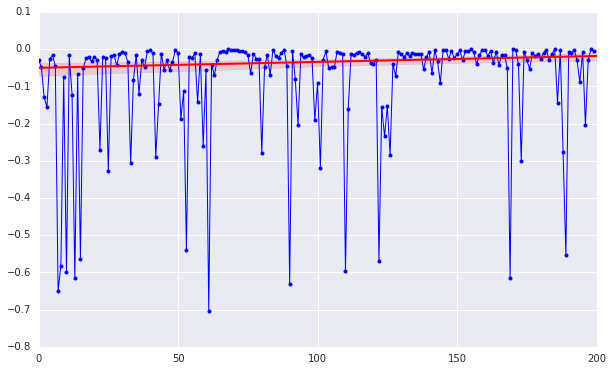

In [38]:
import seaborn as sns
fig,ax = subplots(figsize=(10, 6))
iter_idx = array(range(len(knn_rand_opt.trials.trials)))
iter_val_r2 = 1 - array(knn_rand_opt.trials.losses())
ax.plot(iter_idx, iter_val_r2, 'bo-', markersize=4, linewidth=1)
sns.regplot(iter_idx, iter_val_r2, scatter=False, robust=True, 
            line_kws={'linewidth': 2, 'color': 'red'},
            ax=ax)

In the above plot, each dot represents the R2 scores from CV and the red line represents a robust regression fitted trend. As we can see, as the optimization keeps going, there is a (very weak) positive trend of increasing R2 scores. However, it is disappointing to see that even at higher trial numbers (e.g. >150) the R2 scores can still become very bad (less than -0.6). This is an indication that hyperopt does not capture the relationship between hyperparameters and CV R2 scores very well.

In the following, I'll perform a more detailed analysis on the positive trend using robust regression.

In [39]:
import statsmodels.api as sm
X = sm.add_constant(iter_idx)
y = iter_val_r2
sm.RLM(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                            RLM   Df Residuals:                      198
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 04 Aug 2016                                         
Time:                        22:37:25                                         
No. Iterations:                    42                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0500      0.005     -9.843      0.000        -0.060    -0.040
x1             0.0002   4.42e-05      3.592      0.000      7.21e-05     0.000
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

This indeed confirms that the positive trend is statistically significant. However, the slope coefficient is very small: 2e-4.

Now, I'll use the optimized KNN model to make predictions on the test set. I'll also use the previously defined utility function to examine the test R2 scores at different time horizons.

In [20]:
from sklearn.metrics import r2_score
knn_train_pred = knn_rand_opt.predict(llrt_train_scaled, 
                                      EX_list=[lrng_train_scaled, lvol_train_scaled])
knn_test_pred = knn_rand_opt.predict(llrt_test_scaled, 
                                     EX_list=[lrng_test_scaled, lvol_test_scaled])
r2_list = [r2_score(llrt_train_y, knn_train_pred)]
r2_list.append(1 - knn_rand_opt.trials.best_trial['result']['loss'])
r2_list.extend(r2_in_days(llrt_test_y, knn_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
knn_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['KNN R2'], 
                           columns=['Train', 'Validation', '30d', '60d', '120d', 
                                    '180d', '300d', '500d', '800d', 'all'])
knn_r2_hrzn

,Train,Validation,30d,60d,120d,180d,300d,500d,800d,all
KNN R2,0.043535,0.000617,-0.016165,0.006981,-0.001062,-0.004835,-0.002982,-0.008556,-0.022074,-0.030461


Clearly, we can see that the KNN model does not perform well: the validation score is slightly positive while the test scores are negative at most time horizons. The training score is much better than the validation and test scores. This is easy to understand since a training sample always finds itself as the nearest neighbor on the train set, which biases the result.

**Using randomized KNN regressors to study the correlation between test and validation scores**

In [40]:
n_restarts = 50
knn_restart_scores = pd.DataFrame(index=range(n_restarts), 
                                  columns=['val', 'test'])
fit_start = time.time()
for i in range(n_restarts):
    knn_ = HyperoptEstimator(
        preprocessing=[ts_lagselector('lrt', 1, 20)],
        ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                      [ts_lagselector('vol', 0, 20)] ],
        regressor=knn_regression('knn'),
        algo=rand.suggest,
        max_evals=1)  # one trial, no seed.
    knn_.fit(llrt_train_scaled, llrt_train_y, 
             EX_list=[lrng_train_scaled, lvol_train_scaled], 
             n_folds=5, cv_shuffle=False)
    knn_restart_scores.ix[i, 'val'] = 1 - knn_.trials.best_trial['result']['loss']
    knn_restart_scores.ix[i, 'test'] = knn_.score(llrt_test_scaled, llrt_test_y, 
                                                  EX_list=[lrng_test_scaled, 
                                                           lvol_test_scaled])
print 'Time elapsed:', time.time() - fit_start

Time elapsed: 197.591640949


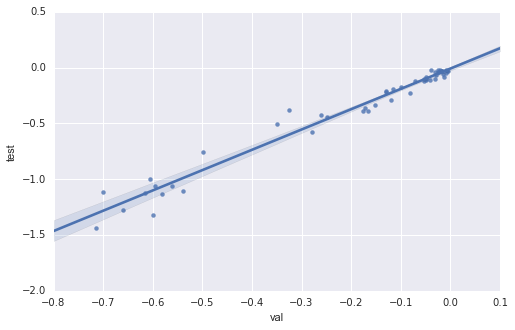

In [51]:
knn_restart_scores = knn_restart_scores.apply(pd.to_numeric)
fig,ax = subplots(figsize=(8, 5))
sns.regplot(x='val', y='test', data=knn_restart_scores, ax=ax)

In [128]:
#knn_restart_scores.to_csv('saved_results/knn_restart_scores.csv')

In [52]:
X = sm.add_constant(knn_restart_scores['val'])
y = knn_restart_scores['test']
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   test   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1575.
Date:                Thu, 04 Aug 2016   Prob (F-statistic):           2.33e-38
Time:                        23:17:10   Log-Likelihood:                 59.630
No. Observations:                  50   AIC:                            -115.3
Df Residuals:                      48   BIC:                            -111.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0088      0.014     -0.623      0.536        -0.037     0.020
val            1.8196      0.046     39.685      0.000         1.727     1.912
==============================================================================
Omnibus:                        7.935   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.899
Skew:                           0.432   Prob(JB):                      0.00430
Kurtosis:                       5.118   Cond. No.                         4.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

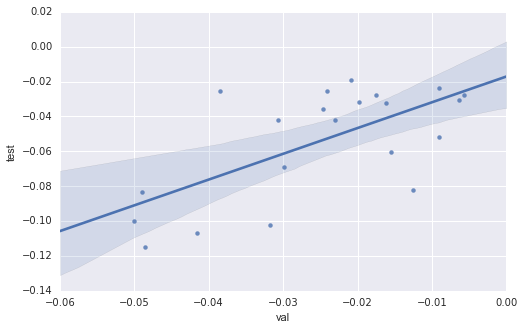

In [57]:
r2_cutoff = -0.05
knn_restart_scores_filtered = knn_restart_scores[knn_restart_scores['val'] > r2_cutoff]
fig,ax = subplots(figsize=(8, 5))
sns.regplot(x='val', y='test', data=knn_restart_scores_filtered, ax=ax)

In [58]:
X = sm.add_constant(knn_restart_scores_filtered['val'])
y = knn_restart_scores_filtered['test']
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   test   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     14.30
Date:                Thu, 04 Aug 2016   Prob (F-statistic):            0.00126
Time:                        23:21:57   Log-Likelihood:                 49.045
No. Observations:                  21   AIC:                            -94.09
Df Residuals:                      19   BIC:                            -92.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0171      0.011     -1.537      0.141        -0.040     0.006
val            1.4773      0.391      3.781      0.001         0.660     2.295
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.300
Skew:                          -0.131   Prob(JB):                        0.860
Kurtosis:                       2.476   Cond. No.                         72.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.3.2 Hybrid approach

In [78]:
fit_start = time.time()
knn_hyb_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=knn_regression('knn'),
    algo=tpe.suggest,
    max_evals=200,
    seed=1)
knn_hyb_rand_opt.fit(lresid_train_scaled, lresid_train_y, 
                     EX_list=[lrng_train_scaled, lvol_train_scaled], 
                     n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print knn_hyb_rand_opt.best_model()

Time elapsed: 814.305259943
Best model found by random search:
{'learner': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=45, p=0,
          weights='uniform'), 'preprocs': (LagSelector(lag_size=13),), 'ex_preprocs': ((LagSelector(lag_size=11),), (LagSelector(lag_size=4),))}


In [79]:
#_ = gzip.open('saved_results/knn_hyb_rand_opt.txt.gz', 'wb').\
#    write(pickle.dumps(knn_hyb_rand_opt))

In [80]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - knn_hyb_rand_opt.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: -0.00139101200687


In [82]:
from sklearn.metrics import r2_score
knn_train_pred = knn_hyb_rand_opt.predict(lresid_train_scaled, 
                                          EX_list=[lrng_train_scaled, 
                                                   lvol_train_scaled])
knn_train_pred += arma_train_pred
knn_test_pred = knn_hyb_rand_opt.predict(lresid_test_scaled, 
                                         EX_list=[lrng_test_scaled, 
                                                  lvol_test_scaled])
knn_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, knn_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, knn_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
knn_hyb_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['KNN Hyb R2'], 
                               columns=['Train', '30d', '60d', '120d', 
                                        '180d', '300d', '500d', '800d', 'all'])
knn_hyb_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
KNN Hyb R2,0.052849,0.046665,0.004673,-0.011197,-0.006287,-0.007806,-0.017172,-0.0285,-0.039314


## 2.4 Random forest and extra trees

The ensemble of decision trees is a class of popular machine learning methods that usually generalize very well. Here I consider two ensemble methods - extra trees and random forest. The extra trees method is a variant of the random forest, in which the cutoff values are randomly generated (instead of optimized) each time the nodes are split. This change makes the generated trees more stochastic than the optimized trees in a random forest and is supposed to reduce variance.

Same as above, I'll define subclasses for the `ExtraTreesRegressor` and the `RandomForestRegressor` classes in sklearn, which allow me to tune the number of lags as a hyperparameter.

### 2.4.1 Direct approach

**Random Forest**

In [13]:
from hyperopt import tpe, rand
from hpsklearn import HyperoptEstimator, random_forest_regression, extra_trees_regression
from hpsklearn.components import ts_lagselector
import time
import copy

fit_start = time.time()
rfr_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=random_forest_regression('rfr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
rfr_rand_opt.fit(llrt_train_scaled, llrt_train_y, 
                 EX_list=[lrng_train_scaled, lvol_train_scaled], 
                 n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print rfr_rand_opt.best_model()

Time elapsed: 9143.65965486
Best model found by random search:
{'learner': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=0.624307969951, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=351, n_jobs=1,
           oob_score=False, random_state=4, verbose=False,
           warm_start=False), 'preprocs': (LagSelector(lag_size=19),), 'ex_preprocs': ((LagSelector(lag_size=12),), (LagSelector(lag_size=7),))}


In [130]:
#pickle.dump(rfr_rand_opt, gzip.open('saved_results/rfr_rand_opt.txt.gz', 'wb'))

In [130]:
#rfr_rand_opt = pickle.load(gzip.open('saved_results/rfr_rand_opt.txt.gz', 'rb'))

In [14]:
from sklearn.metrics import r2_score
rfr_train_pred = rfr_rand_opt.predict(llrt_train_scaled, 
                                      EX_list=[lrng_train_scaled, lvol_train_scaled])
rfr_test_pred = rfr_rand_opt.predict(llrt_test_scaled, 
                                     EX_list=[lrng_test_scaled, lvol_test_scaled])
r2_list = [r2_score(llrt_train_y, rfr_train_pred)]
r2_list.append(1 - rfr_rand_opt.trials.best_trial['result']['loss'])
r2_list.extend(r2_in_days(llrt_test_y, rfr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
rfr_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['RFR R2'], 
                           columns=['Train', 'Validation', '30d', '60d', '120d', 
                                    '180d', '300d', '500d', '800d', 'all'])
rfr_r2_hrzn

,Train,Validation,30d,60d,120d,180d,300d,500d,800d,all
RFR R2,0.119012,0.011029,-0.000498,0.050217,0.031124,0.03002,0.024991,0.020402,0.016369,0.006118


**Extra trees**

In [15]:
fit_start = time.time()
etr_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=extra_trees_regression('etr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
etr_rand_opt.fit(llrt_train_scaled, llrt_train_y, 
                 EX_list=[lrng_train_scaled, lvol_train_scaled], 
                 n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print etr_rand_opt.best_model()

Time elapsed: 1213.5449872
Best model found by random search:
{'learner': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=3,
          max_features=0.684842692001, max_leaf_nodes=None,
          min_samples_leaf=2, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1401, n_jobs=1,
          oob_score=False, random_state=1, verbose=False, warm_start=False), 'preprocs': (LagSelector(lag_size=20),), 'ex_preprocs': ((LagSelector(lag_size=20),), (LagSelector(lag_size=0),))}


In [131]:
#pickle.dump(etr_rand_opt, gzip.open('saved_results/etr_rand_opt.txt.gz', 'wb'))

In [16]:
from sklearn.metrics import r2_score
etr_train_pred = etr_rand_opt.predict(llrt_train_scaled, 
                                      EX_list=[lrng_train_scaled, lvol_train_scaled])
etr_test_pred = etr_rand_opt.predict(llrt_test_scaled, 
                                     EX_list=[lrng_test_scaled, lvol_test_scaled])
r2_list = [r2_score(llrt_train_y, etr_train_pred)]
r2_list.append(1 - etr_rand_opt.trials.best_trial['result']['loss'])
r2_list.extend(r2_in_days(llrt_test_y, etr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
etr_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['ETR R2'], 
                           columns=['Train', 'Validation', '30d', '60d', '120d', 
                                    '180d', '300d', '500d', '800d', 'all'])
etr_r2_hrzn

,Train,Validation,30d,60d,120d,180d,300d,500d,800d,all
ETR R2,0.063832,0.005814,-0.000454,0.023813,0.016386,0.014993,0.01246,0.009913,0.007564,0.005524


### 2.4.2 Hybrid approach

**Random forest**

In [83]:
from hpsklearn import random_forest_regression, extra_trees_regression

fit_start = time.time()
rfr_hyb_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=random_forest_regression('rfr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
rfr_hyb_rand_opt.fit(lresid_train_scaled, lresid_train_y, 
                     EX_list=[lrng_train_scaled, lvol_train_scaled], 
                     n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print rfr_hyb_rand_opt.best_model()

Time elapsed: 4912.08133698
Best model found by random search:
{'learner': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features=0.965412786449, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=1,
           oob_score=False, random_state=1, verbose=False,
           warm_start=False), 'preprocs': (LagSelector(lag_size=7),), 'ex_preprocs': ((LagSelector(lag_size=11),), (LagSelector(lag_size=15),))}


In [84]:
#_ = gzip.open('saved_results/rfr_hyb_rand_opt.txt.gz', 'wb').\
#    write(pickle.dumps(rfr_hyb_rand_opt))

In [5]:
import pickle
import gzip
rfr_hyb_rand_opt = pickle.load(gzip.open('saved_results/rfr_hyb_rand_opt.txt.gz', 'rb'))

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [85]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - rfr_hyb_rand_opt.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: 0.00449864556653


In [86]:
from sklearn.metrics import r2_score
rfr_train_pred = rfr_hyb_rand_opt.predict(lresid_train_scaled, 
                                          EX_list=[lrng_train_scaled, 
                                                   lvol_train_scaled])
rfr_train_pred += arma_train_pred
rfr_test_pred = rfr_hyb_rand_opt.predict(lresid_test_scaled, 
                                         EX_list=[lrng_test_scaled, 
                                                  lvol_test_scaled])
rfr_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, rfr_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, rfr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
rfr_hyb_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['RFR Hyb R2'], 
                               columns=['Train', '30d', '60d', '120d', 
                                        '180d', '300d', '500d', '800d', 'all'])
rfr_hyb_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
RFR Hyb R2,0.072659,-0.022195,0.003197,0.002995,0.004304,0.003392,0.002201,-0.001368,-0.006564


**Option 1: refine the best random forest model using warm start**

In [9]:
import copy
import time
rfr_hyb_rand_opt_refined = copy.deepcopy(rfr_hyb_rand_opt)
rfr_hyb_rand_opt_refined.set_max_evals(50)
fit_start = time.time()
rfr_hyb_rand_opt_refined.fit(lresid_train_scaled, lresid_train_y, 
                             EX_list=[lrng_train_scaled, lvol_train_scaled], 
                             n_folds=5, cv_shuffle=False,
                             warm_start=True)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Refined best model:'
print rfr_hyb_rand_opt_refined.best_model()

Time elapsed: 1221.35629702
Refined best model:
{'learner': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features=0.965412786449, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=1,
           oob_score=False, random_state=1, verbose=False,
           warm_start=False), 'preprocs': (LagSelector(lag_size=7),), 'ex_preprocs': ((LagSelector(lag_size=11),), (LagSelector(lag_size=15),))}


In [11]:
_ = gzip.open('saved_results/rfr_hyb_rand_opt_refined.txt.gz', 'wb').\
    write(pickle.dumps(rfr_hyb_rand_opt_refined))

In [12]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - rfr_hyb_rand_opt_refined.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: 0.00449864556653


**Option 2: use a different random seed**

In [16]:
from hpsklearn import random_forest_regression, extra_trees_regression
from hpsklearn import HyperoptEstimator
from hpsklearn import ts_lagselector
from hyperopt import tpe, rand

fit_start = time.time()
rfr_hyb2_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=random_forest_regression('rfr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=10029)
rfr_hyb2_rand_opt.fit(lresid_train_scaled, lresid_train_y, 
                      EX_list=[lrng_train_scaled, lvol_train_scaled], 
                      n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print rfr_hyb2_rand_opt.best_model()

Time elapsed: 5146.79181385
Best model found by random search:
{'learner': RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=3,
           max_features='log2', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=False, warm_start=False), 'preprocs': (LagSelector(lag_size=19),), 'ex_preprocs': ((LagSelector(lag_size=17),), (LagSelector(lag_size=15),))}


In [17]:
_ = gzip.open('saved_results/rfr_hyb2_rand_opt.txt.gz', 'wb').\
    write(pickle.dumps(rfr_hyb2_rand_opt))

In [18]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - rfr_hyb2_rand_opt.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: 0.00623486621894


In [24]:
from sklearn.metrics import r2_score
rfr_train_pred = rfr_hyb2_rand_opt.\
    predict(lresid_train_scaled, 
            EX_list=[lrng_train_scaled, lvol_train_scaled])
rfr_train_pred += arma_train_pred
rfr_test_pred = rfr_hyb2_rand_opt.\
    predict(lresid_test_scaled, 
            EX_list=[lrng_test_scaled, lvol_test_scaled])
rfr_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, rfr_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, rfr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
rfr_hyb2_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), 
                                index=['RFR Hyb2 R2'], 
                                columns=['Train', '30d', '60d', '120d', 
                                         '180d', '300d', '500d', '800d', 'all'])
rfr_hyb2_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
RFR Hyb2 R2,0.082091,-0.022823,0.019483,0.011852,0.012251,0.009937,0.007482,0.002826,-0.003022


**Extra trees**

In [87]:
fit_start = time.time()
etr_hyb_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=extra_trees_regression('etr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
etr_hyb_rand_opt.fit(lresid_train_scaled, lresid_train_y, 
                     EX_list=[lrng_train_scaled, lvol_train_scaled], 
                     n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print etr_hyb_rand_opt.best_model()

Time elapsed: 674.21773982
Best model found by random search:
{'learner': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=3,
          max_features=0.781870898067, max_leaf_nodes=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=38, n_jobs=1,
          oob_score=False, random_state=1, verbose=False, warm_start=False), 'preprocs': (LagSelector(lag_size=7),), 'ex_preprocs': ((LagSelector(lag_size=14),), (LagSelector(lag_size=5),))}


In [88]:
#_ = gzip.open('saved_results/etr_hyb_rand_opt.txt.gz', 'wb').\
#    write(pickle.dumps(etr_hyb_rand_opt))

In [89]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - etr_hyb_rand_opt.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: 0.00207053480987


In [90]:
from sklearn.metrics import r2_score
etr_train_pred = etr_hyb_rand_opt.predict(lresid_train_scaled, 
                                          EX_list=[lrng_train_scaled, 
                                                   lvol_train_scaled])
etr_train_pred += arma_train_pred
etr_test_pred = etr_hyb_rand_opt.predict(lresid_test_scaled, 
                                         EX_list=[lrng_test_scaled, 
                                                  lvol_test_scaled])
etr_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, etr_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, etr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
etr_hyb_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['ETR Hyb R2'], 
                               columns=['Train', '30d', '60d', '120d', 
                                        '180d', '300d', '500d', '800d', 'all'])
etr_hyb_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
ETR Hyb R2,0.077046,-0.021515,0.015516,0.009786,0.010394,0.008486,0.006486,0.002158,-0.004115


## 2.5 AdaBoost and GradientBoosting

### 2.5.1 Direct approach

**AdaBoost**

In [5]:
from hyperopt import tpe, rand
from hpsklearn import HyperoptEstimator, ada_boost_regression, gradient_boosting_regression
from hpsklearn.components import ts_lagselector
import time
import copy

fit_start = time.time()
abr_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=ada_boost_regression('abr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
abr_rand_opt.fit(llrt_train_scaled, llrt_train_y, 
                 EX_list=[lrng_train_scaled, lvol_train_scaled], 
                 n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print abr_rand_opt.best_model()

Time elapsed: 956.798409939
Best model found by random search:
{'learner': AdaBoostRegressor(base_estimator=None, learning_rate=0.0479659177429,
         loss='square', n_estimators=98, random_state=1), 'preprocs': (LagSelector(lag_size=19),), 'ex_preprocs': ((LagSelector(lag_size=20),), (LagSelector(lag_size=1),))}


In [6]:
import gzip, pickle
pickle.dump(abr_rand_opt, gzip.open('saved_results/abr_rand_opt.txt.gz', 'wb'))

In [130]:
#abr_rand_opt = pickle.load(gzip.open('saved_results/abr_rand_opt.txt.gz', 'rb'))

In [7]:
from sklearn.metrics import r2_score
abr_train_pred = abr_rand_opt.predict(llrt_train_scaled, 
                                      EX_list=[lrng_train_scaled, lvol_train_scaled])
abr_test_pred = abr_rand_opt.predict(llrt_test_scaled, 
                                     EX_list=[lrng_test_scaled, lvol_test_scaled])
r2_list = [r2_score(llrt_train_y, abr_train_pred)]
r2_list.append(1 - abr_rand_opt.trials.best_trial['result']['loss'])
r2_list.extend(r2_in_days(llrt_test_y, abr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
abr_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['ABR R2'], 
                           columns=['Train', 'Validation', '30d', '60d', '120d', 
                                    '180d', '300d', '500d', '800d', 'all'])
abr_r2_hrzn

,Train,Validation,30d,60d,120d,180d,300d,500d,800d,all
ABR R2,0.082261,0.007725,-0.005134,-0.002027,-0.000367,-0.001511,-0.002244,-0.004453,-0.006912,-0.004687


**GradientBoosting**

In [8]:
fit_start = time.time()
gbr_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=gradient_boosting_regression('gbr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
gbr_rand_opt.fit(llrt_train_scaled, llrt_train_y, 
                 EX_list=[lrng_train_scaled, lvol_train_scaled], 
                 n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print gbr_rand_opt.best_model()

Time elapsed: 1370.15038586
Best model found by random search:
{'learner': GradientBoostingRegressor(alpha=0.9, init=None,
             learning_rate=0.00863333113821, loss='ls', max_depth=None,
             max_features=0.38222967984, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=78, presort='auto',
             random_state=3, subsample=0.85620102628, verbose=0,
             warm_start=False), 'preprocs': (LagSelector(lag_size=5),), 'ex_preprocs': ((LagSelector(lag_size=11),), (LagSelector(lag_size=12),))}


In [9]:
pickle.dump(gbr_rand_opt, gzip.open('saved_results/gbr_rand_opt.txt.gz', 'wb'))

In [10]:
gbr_train_pred = gbr_rand_opt.predict(llrt_train_scaled, 
                                      EX_list=[lrng_train_scaled, lvol_train_scaled])
gbr_test_pred = gbr_rand_opt.predict(llrt_test_scaled, 
                                     EX_list=[lrng_test_scaled, lvol_test_scaled])
r2_list = [r2_score(llrt_train_y, gbr_train_pred)]
r2_list.append(1 - gbr_rand_opt.trials.best_trial['result']['loss'])
r2_list.extend(r2_in_days(llrt_test_y, gbr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
gbr_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['GBR R2'], 
                           columns=['Train', 'Validation', '30d', '60d', '120d', 
                                    '180d', '300d', '500d', '800d', 'all'])
gbr_r2_hrzn

,Train,Validation,30d,60d,120d,180d,300d,500d,800d,all
GBR R2,0.687412,0.009733,-0.019627,0.058173,0.025608,0.021697,0.018264,0.017015,0.007811,-0.012533


### 2.5.2 Hybrid approach

**AdaBoost**

In [11]:
fit_start = time.time()
abr_hyb_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=ada_boost_regression('abr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
abr_hyb_rand_opt.fit(lresid_train_scaled, lresid_train_y, 
                     EX_list=[lrng_train_scaled, lvol_train_scaled], 
                     n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print abr_hyb_rand_opt.best_model()

Time elapsed: 635.32884717
Best model found by random search:
{'learner': AdaBoostRegressor(base_estimator=None, learning_rate=0.0128716277143,
         loss='square', n_estimators=15, random_state=0), 'preprocs': (LagSelector(lag_size=17),), 'ex_preprocs': ((LagSelector(lag_size=15),), (LagSelector(lag_size=6),))}


In [12]:
pickle.dump(abr_hyb_rand_opt, gzip.open('saved_results/abr_hyb_rand_opt.txt.gz', 'wb'))

In [ ]:
#import pickle
#import gzip
#abr_hyb_rand_opt = pickle.load(gzip.open('saved_results/abr_hyb_rand_opt.txt.gz', 'rb'))

In [13]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - abr_hyb_rand_opt.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: 0.00662402767807


In [14]:
from sklearn.metrics import r2_score
abr_train_pred = abr_hyb_rand_opt.predict(lresid_train_scaled, 
                                          EX_list=[lrng_train_scaled, 
                                                   lvol_train_scaled])
abr_train_pred += arma_train_pred
abr_test_pred = abr_hyb_rand_opt.predict(lresid_test_scaled, 
                                         EX_list=[lrng_test_scaled, 
                                                  lvol_test_scaled])
abr_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, abr_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, abr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
abr_hyb_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['ABR Hyb R2'], 
                               columns=['Train', '30d', '60d', '120d', 
                                        '180d', '300d', '500d', '800d', 'all'])
abr_hyb_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
ABR Hyb R2,0.057359,-0.02076,-0.046178,-0.02395,-0.01994,-0.016656,-0.014114,-0.014497,-0.022998


**GradientBoosting**

In [15]:
fit_start = time.time()
gbr_hyb_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=gradient_boosting_regression('gbr'),
    algo=tpe.suggest,
    max_evals=50,
    seed=1)
gbr_hyb_rand_opt.fit(lresid_train_scaled, lresid_train_y, 
                     EX_list=[lrng_train_scaled, lvol_train_scaled], 
                     n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print gbr_hyb_rand_opt.best_model()

Time elapsed: 903.371691227
Best model found by random search:
{'learner': GradientBoostingRegressor(alpha=0.9, init=None,
             learning_rate=0.00410593606526, loss='ls', max_depth=None,
             max_features='log2', max_leaf_nodes=None, min_samples_leaf=2,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=54, presort='auto', random_state=3,
             subsample=0.953800047241, verbose=0, warm_start=False), 'preprocs': (LagSelector(lag_size=18),), 'ex_preprocs': ((LagSelector(lag_size=15),), (LagSelector(lag_size=8),))}


In [16]:
pickle.dump(gbr_hyb_rand_opt, gzip.open('saved_results/gbr_hyb_rand_opt.txt.gz', 'wb'))

In [ ]:
#import pickle
#import gzip
#gbr_hyb_rand_opt = pickle.load(gzip.open('saved_results/gbr_hyb_rand_opt.txt.gz', 'rb'))

In [17]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - gbr_hyb_rand_opt.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: 0.00134348589657


In [18]:
from sklearn.metrics import r2_score
gbr_train_pred = gbr_hyb_rand_opt.predict(lresid_train_scaled, 
                                          EX_list=[lrng_train_scaled, 
                                                   lvol_train_scaled])
gbr_train_pred += arma_train_pred
gbr_test_pred = gbr_hyb_rand_opt.predict(lresid_test_scaled, 
                                         EX_list=[lrng_test_scaled, 
                                                  lvol_test_scaled])
gbr_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, gbr_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, gbr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
gbr_hyb_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['GBR Hyb R2'], 
                               columns=['Train', '30d', '60d', '120d', 
                                        '180d', '300d', '500d', '800d', 'all'])
gbr_hyb_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
GBR Hyb R2,0.320706,-0.03206,0.022709,0.015792,0.015477,0.013051,0.010205,0.004681,-0.00274


## 2.x Support vector machines

### 2.x.1 SVM - direct approach

**SVM optimized with K-fold cross-validation**

Next, I'll build an SVM with nonlinear kernels to directly predict S&P500. Since I don't know which kernel to use, I'll let hpsklearn to decide that too.

**Use random search**

In [25]:
from hyperopt import tpe, rand
from hpsklearn import HyperoptEstimator, svr
from hpsklearn.components import ts_lagselector
import time
import copy

fit_start = time.time()
svr_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=svr('svr', max_iter=5e6),
    algo=rand.suggest,
    max_evals=50,
    seed=1)
svr_rand_opt.fit(llrt_train_scaled, llrt_train_y, 
                 EX_list=[lrng_train_scaled, lvol_train_scaled], 
                 n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print svr_rand_opt.best_model()

Time elapsed: 7285.75991893
Best model found by random search:
{'learner': SVR(C=6.14316913268e-05, cache_size=512, coef0=0.0, degree=1,
  epsilon=0.00122638050433, gamma='auto', kernel='linear',
  max_iter=5000000.0, shrinking=True, tol=2.38136481865e-05, verbose=False), 'preprocs': (LagSelector(lag_size=14),), 'ex_preprocs': ((LagSelector(lag_size=13),), (LagSelector(lag_size=20),))}


In [26]:
pickle.dump(svr_rand_opt, gzip.open('saved_results/svr_rand_opt.txt.gz', 'wb'))

In [6]:
import pickle, gzip
svr_rand_opt = pickle.load(gzip.open('saved_results/svr_rand_opt.txt.gz', 'rb'))

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [32]:
from sklearn.metrics import r2_score
svr_train_pred = svr_rand_opt.predict(llrt_train_scaled, 
                                      EX_list=[lrng_train_scaled, lvol_train_scaled])
svr_test_pred = svr_rand_opt.predict(llrt_test_scaled, 
                                     EX_list=[lrng_test_scaled, lvol_test_scaled])
r2_list = [r2_score(llrt_train_y, svr_train_pred)]
r2_list.append(1 - svr_rand_opt.trials.best_trial['result']['loss'])
r2_list.extend(r2_in_days(llrt_test_y, svr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
svr_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['SVR R2'], 
                           columns=['Train', 'Validation', '30d', '60d', '120d', 
                                    '180d', '300d', '500d', '800d', 'all'])
svr_r2_hrzn

,Train,Validation,30d,60d,120d,180d,300d,500d,800d,all
SVR R2,0.015575,0.000096,-0.039342,-0.004182,-0.002238,-0.001335,-0.003569,-0.000603,-0.005412,-0.007036


**Refine the best model found**

In [28]:
svr_rand_refined = copy.deepcopy(svr_rand_opt)
svr_rand_refined.set_max_evals(50)
svr_rand_refined.set_algo(tpe.suggest)
fit_start = time.time()
svr_rand_refined.fit(llrt_train_scaled, llrt_train_y, 
                     EX_list=[lrng_train_scaled, lvol_train_scaled], 
                     warm_start=True, n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Refined best model:'
print svr_rand_refined.best_model()

Time elapsed: 33278.2932019
Refined best model:
{'learner': SVR(C=9.01406846603e-05, cache_size=512, coef0=0.0, degree=1,
  epsilon=0.00270678499534, gamma='auto', kernel='linear',
  max_iter=5000000.0, shrinking=True, tol=0.000311374866663, verbose=False), 'preprocs': (LagSelector(lag_size=12),), 'ex_preprocs': ((LagSelector(lag_size=10),), (LagSelector(lag_size=20),))}


In [29]:
#pickle.dump(svr_rand_refined, gzip.open('saved_results/svr_rand_refined.txt.gz', 'wb'))

In [20]:
svr_rand_refined = pickle.load(gzip.open('saved_results/svr_rand_refined.txt.gz', 'rb'))

In [21]:
from sklearn.metrics import r2_score
svr_train_pred = svr_rand_refined.predict(llrt_train_scaled, 
                                          EX_list=[lrng_train_scaled, lvol_train_scaled])
svr_test_pred = svr_rand_refined.predict(llrt_test_scaled, 
                                         EX_list=[lrng_test_scaled, lvol_test_scaled])
r2_list = [r2_score(llrt_train_y, svr_train_pred)]
r2_list.append(1 - svr_rand_refined.trials.best_trial['result']['loss'])
r2_list.extend(r2_in_days(llrt_test_y, svr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
svr_refined_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['SVR Refined R2'], 
                                   columns=['Train', 'Validation', '30d', '60d', '120d', 
                                            '180d', '300d', '500d', '800d', 'all'])
svr_refined_r2_hrzn

,Train,Validation,30d,60d,120d,180d,300d,500d,800d,all
SVR Refined R2,0.017417,0.002524,-0.031682,0.002319,-0.001981,-0.003223,-0.003338,0.00022,-0.004313,-0.005668


### 2.x.2 Hybrid approach

**SVM optimized with K-fold cross-validation**

In [22]:
from hyperopt import tpe, rand
from hpsklearn import HyperoptEstimator, svr
from hpsklearn.components import ts_lagselector
import time
import copy

fit_start = time.time()
svr_hyb_rand_opt = HyperoptEstimator(
    preprocessing=[ts_lagselector('lrt', 1, 20)],
    ex_preprocs=[ [ts_lagselector('rng', 0, 20)], 
                  [ts_lagselector('vol', 0, 20)] ],
    regressor=svr('svr', max_iter=5e6),
    algo=rand.suggest,
    max_evals=50,
    seed=1)
svr_hyb_rand_opt.fit(lresid_train_scaled, lresid_train_y, 
                     EX_list=[lrng_train_scaled, lvol_train_scaled], 
                     n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Best model found by random search:'
print svr_hyb_rand_opt.best_model()

Time elapsed: 23992.8537149
Best model found by random search:
{'learner': SVR(C=0.000402786628299, cache_size=512, coef0=0.0, degree=1,
  epsilon=0.022247391504, gamma=0.204034217093, kernel='rbf',
  max_iter=5000000.0, shrinking=False, tol=1.9778069088e-05, verbose=False), 'preprocs': (LagSelector(lag_size=12),), 'ex_preprocs': ((LagSelector(lag_size=5),), (LagSelector(lag_size=14),))}


In [23]:
pickle.dump(svr_hyb_rand_opt, gzip.open('saved_results/svr_hyb_rand_opt.txt.gz', 'wb'))

In [7]:
svr_hyb_rand_opt = pickle.load(gzip.open('saved_results/svr_hyb_rand_opt.txt.gz', 'rb'))

In [24]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - svr_hyb_rand_opt.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: -0.00109167535274


In [25]:
from sklearn.metrics import r2_score
svr_train_pred = svr_hyb_rand_opt.predict(lresid_train_scaled, 
                                          EX_list=[lrng_train_scaled, 
                                                   lvol_train_scaled])
svr_train_pred += arma_train_pred
svr_test_pred = svr_hyb_rand_opt.predict(lresid_test_scaled, 
                                         EX_list=[lrng_test_scaled, 
                                                  lvol_test_scaled])
svr_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, svr_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, svr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
svr_hyb_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['SVR Hyb R2'], 
                               columns=['Train', '30d', '60d', '120d', 
                                        '180d', '300d', '500d', '800d', 'all'])
svr_hyb_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
SVR Hyb R2,0.024867,-0.033599,0.005239,0.001922,0.00141,-0.000202,-0.004032,-0.010414,-0.011987


**Refine best model**

In [10]:
from hyperopt import tpe, rand
from hpsklearn import HyperoptEstimator, svr
from hpsklearn.components import ts_lagselector
import time
import copy

svr_hyb_rand_refined = copy.deepcopy(svr_hyb_rand_opt)
svr_hyb_rand_refined.max_evals = 50
svr_hyb_rand_refined.algo = tpe.suggest
fit_start = time.time()
svr_hyb_rand_refined.fit(lresid_train_scaled, lresid_train_y, 
                         EX_list=[lrng_train_scaled, lvol_train_scaled], 
                         warm_start=True, n_folds=5, cv_shuffle=False)
print 'Time elapsed:', time.time() - fit_start
print '=' * 10
print 'Refined best model:'
print svr_hyb_rand_refined.best_model()

Time elapsed: 2971.89023614
Refined best model:
{'learner': SVR(C=0.000506017282702, cache_size=512, coef0=0.0, degree=1,
  epsilon=0.0077730861729, gamma=539.451319479, kernel='rbf',
  max_iter=5000000.0, shrinking=False, tol=0.000969822991271,
  verbose=False), 'preprocs': (LagSelector(lag_size=10),), 'ex_preprocs': ((LagSelector(lag_size=9),), (LagSelector(lag_size=10),))}


In [11]:
pickle.dump(svr_hyb_rand_refined, gzip.open('saved_results/svr_hyb_rand_refined.txt.gz', 'wb'))

In [12]:
print 'Best validation R2 score on ARMA residuals:', \
    1 - svr_hyb_rand_refined.trials.best_trial['result']['loss']

Best validation R2 score on ARMA residuals: -0.000956829355356


In [13]:
from sklearn.metrics import r2_score
svr_train_pred = svr_hyb_rand_refined.predict(lresid_train_scaled, 
                                              EX_list=[lrng_train_scaled, 
                                                       lvol_train_scaled])
svr_train_pred += arma_train_pred
svr_test_pred = svr_hyb_rand_refined.predict(lresid_test_scaled, 
                                             EX_list=[lrng_test_scaled, 
                                                      lvol_test_scaled])
svr_test_pred += arma_test_pred
r2_list = [r2_score(llrt_train_y, svr_train_pred)]
r2_list.extend(r2_in_days(llrt_test_y, svr_test_pred, 
                          [30, 60, 120, 180, 300, 500, 800, 'all']))
svr_hyb_refined_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), 
                                       index=['SVR Hyb Refined R2'], 
                                       columns=['Train', '30d', '60d', '120d', 
                                                '180d', '300d', '500d', '800d', 
                                                'all'])
svr_hyb_refined_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,800d,all
SVR Hyb Refined R2,0.053293,-0.022903,0.003553,0.002928,0.004078,0.003098,0.001719,-0.002044,-0.004657
